In [131]:
import os 
import pandas as pd 
from sklearn.model_selection import train_test_split

Load the Data


In [132]:
benign ='data/archive/Dataset_BUSI_with_GT/benign'
malignant='data/archive/Dataset_BUSI_with_GT/malignant'
normal='data/archive/Dataset_BUSI_with_GT/normal'

In [133]:
count_benign=len(os.listdir(benign))
count_malignant=len(os.listdir(malignant))
count_normal=len(os.listdir(normal))

print((count_benign))
print(count_malignant)
print(count_normal)

891
421
266


Look at the data

In [134]:
def create_data(data_dir, categories):
    images = []
    masks = []
    labels = []

    for i, category in enumerate(categories):
        category_dir = os.path.join(data_dir, category)
        for file_name in os.listdir(category_dir):
            if "_mask" in file_name:
                continue
            image_file_path = os.path.join(category_dir, file_name)
            mask_file_name = file_name.replace(".", "_mask.")
            mask_file_path = os.path.join(category_dir, mask_file_name)
            if not os.path.exists(mask_file_path):
                continue
            images.append(image_file_path)
            masks.append(mask_file_path)
            labels.append(category)

    print(f"Found {len(images)} image/mask pairs in {len(categories)} categories")
    return images, masks, labels

In [135]:
data_dir ="data/archive/Dataset_BUSI_with_GT"

categories = ['benign','malignant','normal']

images,masks,labels=create_data(data_dir,categories)

Found 780 image/mask pairs in 3 categories


In [136]:
df = pd.DataFrame({'image':images,'mask':masks,'label':labels})

In [229]:
df

,image,mask,label
0,data/archive/Dataset_BUSI_with_GT\benign\benig...,data/archive/Dataset_BUSI_with_GT\benign\benig...,benign
1,data/archive/Dataset_BUSI_with_GT\benign\benig...,data/archive/Dataset_BUSI_with_GT\benign\benig...,benign
2,data/archive/Dataset_BUSI_with_GT\benign\benig...,data/archive/Dataset_BUSI_with_GT\benign\benig...,benign
3,data/archive/Dataset_BUSI_with_GT\benign\benig...,data/archive/Dataset_BUSI_with_GT\benign\benig...,benign
4,data/archive/Dataset_BUSI_with_GT\benign\benig...,data/archive/Dataset_BUSI_with_GT\benign\benig...,benign
...,...,...,...
775,data/archive/Dataset_BUSI_with_GT\normal\norma...,data/archive/Dataset_BUSI_with_GT\normal\norma...,normal
776,data/archive/Dataset_BUSI_with_GT\normal\norma...,data/archive/Dataset_BUSI_with_GT\normal\norma...,normal
777,data/archive/Dataset_BUSI_with_GT\normal\norma...,data/archive/Dataset_BUSI_with_GT\normal\norma...,normal
778,data/archive/Dataset_BUSI_with_GT\normal\norma...,data/archive/Dataset_BUSI_with_GT\normal\norma...,normal


In [263]:
df_train,df_test=train_test_split(df,test_size=0.1)

train_labels = df_train["label"]
test_labels = df_test["label"]

In [264]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import random

def plot_data(data,label):
  
  index = data[(data["label"] == label)].sample(1).index[0]
  row = data.iloc[index]
  
  img = cv2.imread(row['image'])
  msk = cv2.imread(row['mask'])
  label = row['label']

  fig, axs = plt.subplots(1, 3, figsize=(15, 5))
  axs[0].imshow(img)
  axs[0].set_title('Image')
  axs[1].imshow(msk)
  axs[1].set_title('Mask')
  axs[2].text(0.5, 0.5, f'Label: {label}', ha='center', va='center', fontsize=16)
  axs[2].axis('off')
  plt.show()

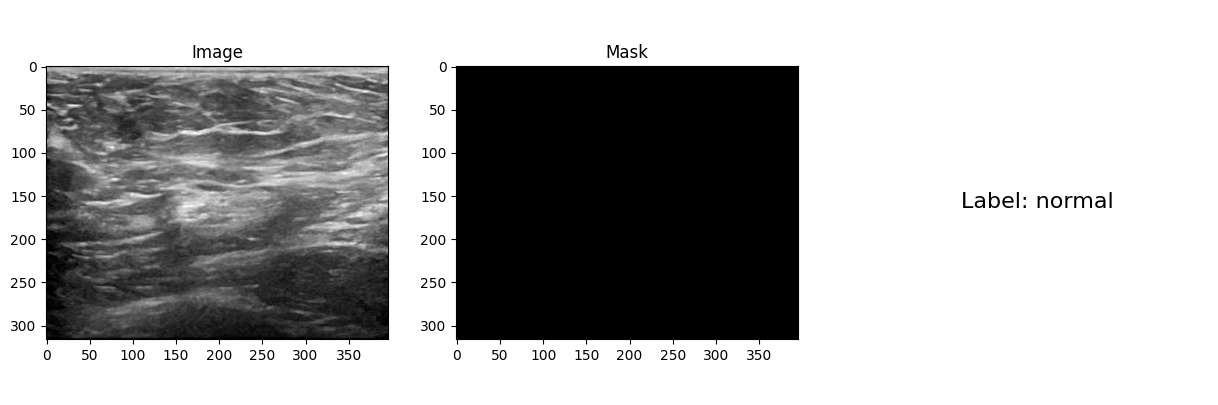

In [265]:
plot_data(df,"normal")

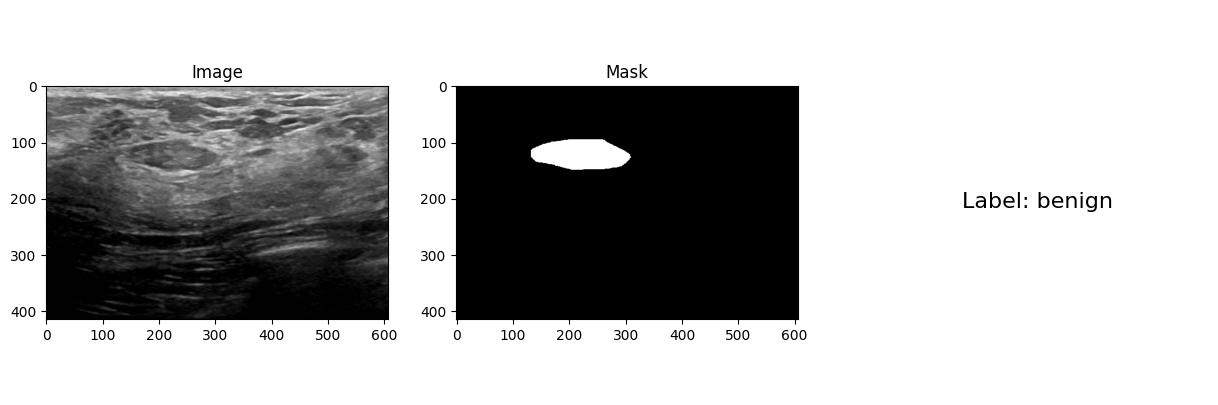

In [266]:
plot_data(df,"benign")

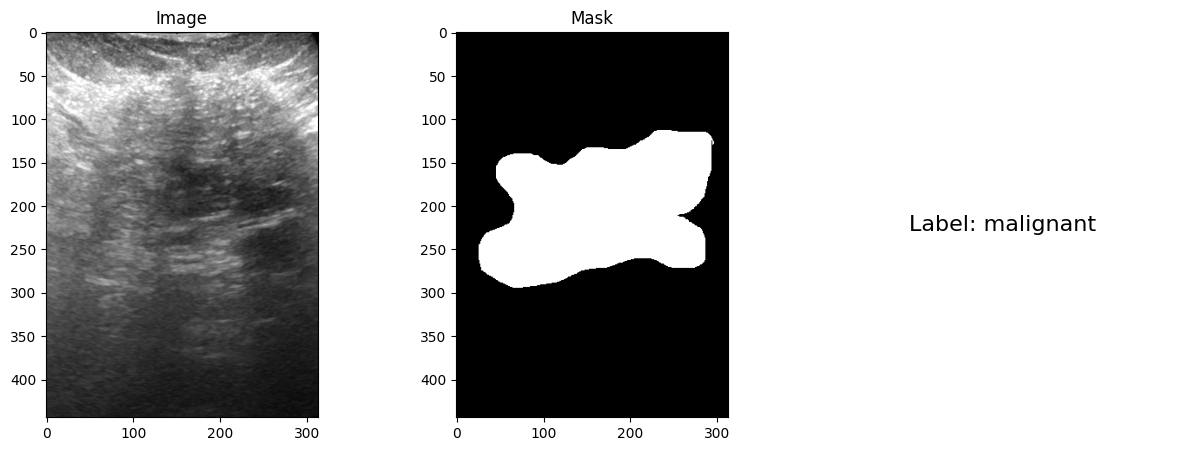

In [267]:
plot_data(df,"malignant")

In [278]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms


class ImagesDataset(Dataset):
    """Reads in an image, transforms pixel values, and serves
    a dictionary containing the image id, image tensors, and label.
    """

    def __init__(self, x_df, y_df=None):
        self.data = x_df
        self.label = y_df
        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                ),
            ]
        )

    def __getitem__(self, index):
        image = Image.open(self.data.iloc[index]["image"]).convert("RGB")
        image = self.transform(image)
        image_id = self.data.index[index]
        # if we don't have labels (e.g. for test set) just return the image and image id
        if self.label is None:
            sample = {"image_id": image_id, "image": image}
        else:
            label = torch.tensor(self.label.iloc[index], 
                                 dtype=torch.float)
            sample = {"image_id": image_id, "image": image, "label": label}
        return sample

    def __len__(self):
        return len(self.data)

In [279]:
from torch.utils.data import DataLoader

train_dataset = ImagesDataset(df_train, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=32)

In [280]:
from torch import nn
import torchvision.models as models


model = models.resnet50(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(2048, 100),  # dense layer takes a 2048-dim input and outputs 100-dim
    nn.ReLU(inplace=True),  # ReLU activation introduces non-linearity
    nn.Dropout(0.1),  # common technique to mitigate overfitting
    nn.Linear(
        100, 8
    ),  # final dense layer outputs 8-dim corresponding to our target classes
)

In [281]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [282]:
num_epochs = 1

tracking_loss = {}

for epoch in range(1, num_epochs + 1):
    print(f"Starting epoch {epoch}")

    # iterate through the dataloader batches. tqdm keeps track of progress.
    for batch_n, batch in tqdm(
        enumerate(train_dataloader), total=len(train_dataloader)
    ):

        # 1) zero out the parameter gradients so that gradients from previous batches are not used in this step
        optimizer.zero_grad()

        # 2) run the foward step on this batch of images
        outputs = model(batch["image"])

        # 3) compute the loss
        loss = criterion(outputs, batch["label"])
        # let's keep track of the loss by epoch and batch
        tracking_loss[(epoch, batch_n)] = float(loss)

        # 4) compute our gradients
        loss.backward()
        # update our weights
        optimizer.step()

Starting epoch 1


  0%|          | 0/22 [00:00<?, ?it/s]


TypeError: new(): invalid data type 'str'